In [6]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import make_interp_spline
from scipy import stats
from scipy import optimize
from sklearn.decomposition import PCA
from scipy.integrate import quad
from matplotlib.pyplot import cm
plt.rcParams['figure.figsize'] = [12., 8.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

# Load some angular acceptance models

In [7]:
# load different holeice models
h3 = pd.read_csv('/home/peller/retro/data/sampled_dom_angsens__hole_ice_model__as.h3-30cm.csv')
h3 = h3.values[1:].astype(np.float32)
h2 = pd.read_csv('/home/peller/retro/data/sampled_dom_angsens__hole_ice_model__as.h2-50cm.csv')
h2 = h2.values[1:].astype(np.float32)
h1 = pd.read_csv('/home/peller/retro/data/sampled_dom_angsens__hole_ice_model__as.h1-100cm.csv')
h1 = h1.values[1:].astype(np.float32)
nom = pd.read_csv('/home/peller/retro/data/sampled_dom_angsens__hole_ice_model__as.nominal.csv')
nom = nom.values[1:].astype(np.float32)

xnew = nom[:,0]

def msu(coseta, p1=0.3, p2=0):
    '''
    MSU parameterization 
    https://wiki.icecube.wisc.edu/index.php/MSU_Forward_Hole_Ice
    '''
    return 0.34 * (1 + 1.5 * coseta - coseta**3/2.) + p1 * coseta * (coseta**2 -1)**3 +p2 * np.exp(10*(coseta-1.2))

greco = msu(xnew, p1=(0.3+0.49*0.1), p2=-0.63)
dragon = msu(xnew, p1=(0.3-0.25*0.1), p2=-1.15)
dima = msu(xnew, p1=0.3, p2=0)
dima2 = msu(xnew, p1=0.2, p2=0)
dima3 = msu(xnew, p1=0.4, p2=0)
baseline = msu(xnew, p1=0.3, p2=-1)
msu2 = msu(xnew, p1=0.3, p2=1)
h3_model = h3[:,1]
h2_model = h2[:,1]
h1_model = h1[:,1]
nominal = nom[:,1]

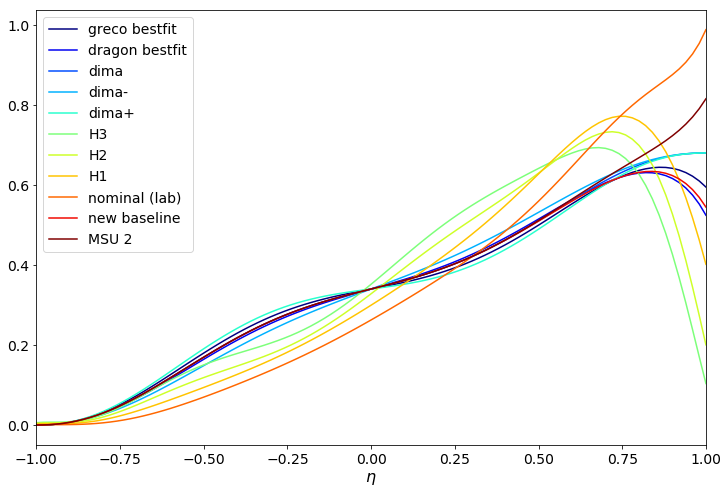

In [10]:
targets = [greco, dragon, dima, dima2, dima3, h3_model, h2_model, h1_model, nominal, baseline, msu2]
names = ['greco bestfit', 'dragon bestfit', 'dima', 'dima-', 'dima+', 'H3', 'H2', 'H1', 'nominal (lab)', 'new baseline', 'MSU 2']
colors = cm.jet(np.linspace(0,1,len(names)))

for target, name, color in zip(targets, names, colors):
    plt.plot(xnew, target, label=name, c=color)

plt.gca().set_xlim([-1,1])
plt.gca().set_xlabel(r'$\eta$')
plt.gca().legend(loc='best')
plt.savefig('all.png')

# Approximate those by splines

greco bestfit
[0.         0.12461764 0.28905443 0.35603659 0.49794749 0.63547174
 0.61221289]
dragon bestfit
[0.         0.11344589 0.27288053 0.36435486 0.51262791 0.60388651
 0.55782469]
dima
[0.         0.11683799 0.2790973  0.36014205 0.50974395 0.6741596
 0.6787052 ]
dima-
[0.         0.10146522 0.25778367 0.37037138 0.53107924 0.67446301
 0.67913676]
dima+
[0.         0.13221036 0.30041105 0.34991281 0.48840848 0.673856
 0.67827345]
H3
[0.         0.11296154 0.2191295  0.42438193 0.64427818 0.4040646
 0.17507187]
H2
[0.         0.08666057 0.19440604 0.39575865 0.6295798  0.50077851
 0.28084327]
H1
[0.         0.06265704 0.18195267 0.35560009 0.62430838 0.62922789
 0.46680058]
nominal (lab)
[0.         0.04042336 0.15699203 0.30913611 0.56189404 0.89338296
 0.94409715]
new baseline
[0.         0.1172303  0.27832482 0.36158166 0.50761365 0.61298662
 0.57349791]
MSU 2
[0.         0.11644551 0.27987019 0.35870268 0.51187405 0.7353326
 0.78391254]


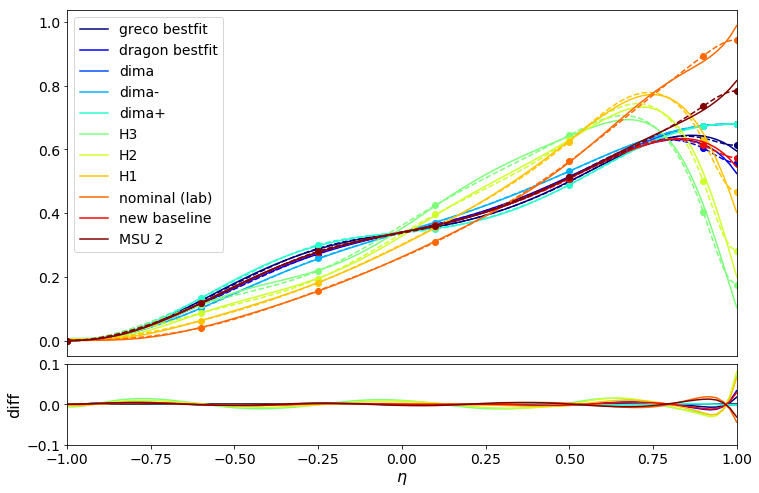

In [11]:
#support_x = np.array([-1., -0.25,  0.5,  0.9,  1.])
#initial_y = np.array([-0.1, 0.2, 0.5, 0.5, 0.5])

support_x = np.array([-1., -0.6, -0.25,  0.1, 0.5,  0.9,  1.])
initial_y = np.array([-0.1, 0.2, 0.2, 0.5, 0.5, 0.5, 0.5])

# this sets the derivative=0 boundary conditions
bc_type=([(1, 0.0)], [(1, 0.0)])

def fun(y, support_x, target):
    '''
    Minimizer objective
    '''
    # we fix the leftmost point to 0
    y[0] = 0
    cubic = make_interp_spline(support_x, y, bc_type=bc_type)
    diff = target - cubic(xnew)
    return np.sqrt(np.sum(np.square(diff)))

fig = plt.figure()
ax1 = plt.subplot2grid((10,1), (0,0), rowspan=8, fig=fig)
ax2 = plt.subplot2grid((10,1), (8,0),sharex=ax1,rowspan=2, fig=fig)

y_points = []

for target, name, color in zip(targets, names, colors):
    opt = optimize.minimize(fun, x0=initial_y, method='L-BFGS-B', args=(support_x, target))
    y = opt['x']
    y_points.append(y)
    print name
    print y

    cubic = make_interp_spline(support_x, y, bc_type=bc_type)
    ax1.plot(support_x, y, 'o', c=color)
    ax1.plot(xnew, cubic(xnew), '--', c=color)
    ax1.plot(xnew, target, label=name, c=color)
    ax2.plot(xnew, cubic(xnew) - target, c=color)

y_points = np.stack(y_points)

ax1.set_xlim([-1,1])
ax2.set_xlim([-1,1])
ax1.get_xaxis().set_visible(False)

ax2.set_ylim([-0.1, 0.1])
ax2.hlines(0,-1,1)
ax2.set_ylabel('diff')
ax2.set_xlabel(r'$\eta$')

ax1.legend(loc='best')
plt.show()
fig.savefig('approx.png')

# Reduce dimensionality
by doing a PCA decomposition and taking the two most important components

In [12]:
transformer = PCA(n_components=2, random_state=0)
out = transformer.fit_transform(y_points)

-1.6401021954689813e-16 4.146306931349776
-1.923966036992459e-17 13.95698135280728


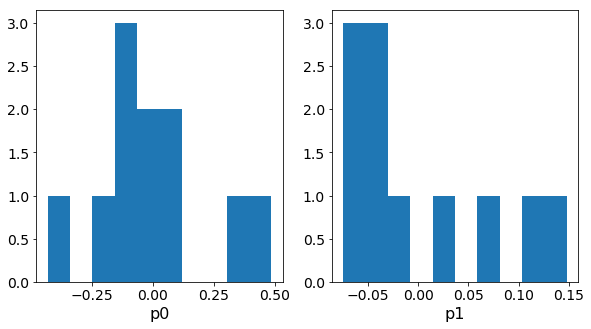

In [13]:
# let's investigate the interesting parameter ranges

fig = plt.figure(figsize=(15,5))
for i in range(out.shape[1]):
    ax = plt.subplot2grid((1,out.shape[1]+1), (0,i), rowspan=1, fig=fig)
    ax.hist(out[:,i])
    ax.set_xlabel('p%i'%i)
    print np.mean(out[:,i]), 1./ np.std(out[:,i])
plt.savefig('dist.png')

In [14]:
# now then build a function with 2 parameters

def ang(params, values):
    '''
    New angular acceptance funcion
    
    params : list / array
        the two parametrrs p1 and p2
    values : array
        the eta values to compute the angular acceptance for in (-1, 1)
    '''
    transformed_params = transformer.inverse_transform(params)
    f = make_interp_spline(support_x, transformed_params, bc_type=bc_type)
    positive_f = lambda x : np.clip(f(x), 0., None)
    
    norm = quad(positive_f, -1, 1)
    out = positive_f(values)
    #normalize....why 0.68?
    out /= norm[0] / 0.68
    
    return out

# Samples & Envelope
let's do some random sampling of the new function

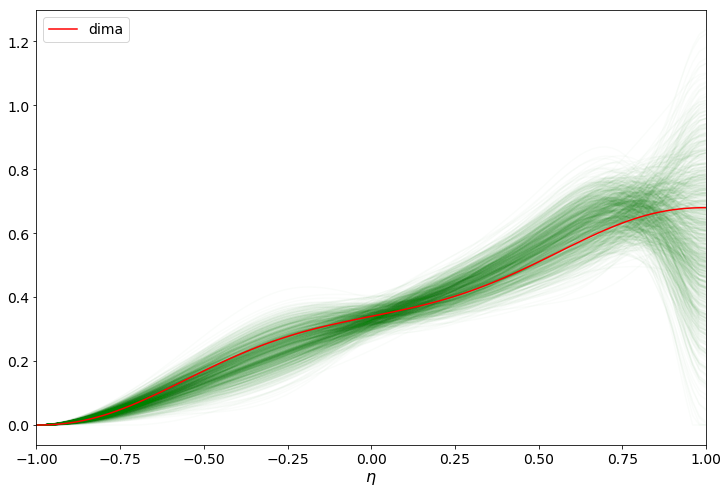

In [15]:
n = 1000

all_curves = np.ones(shape=(n, xnew.shape[0]))

for i in xrange(n):
    params = []
    for j in range(out.shape[1]):
        r = np.random.randn(1)
        params.append(r[0] * np.std(out[:,j]))
    all_curves[i] = ang(params, xnew)
    plt.plot(xnew, all_curves[i], c='green', alpha=20./n)
    #plt.plot(xnew, cubic(xnew), c='green', alpha=20./n)
                
plt.gca().set_xlim([-1,1])    
#plt.plot(xnew, msu(xnew, p1=0.2, p2=0), c='k')
plt.plot(xnew, msu(xnew, p1=0.3, p2=0), c='r', label='dima')
#plt.plot(xnew, msu(xnew, p1=0.4, p2=0), c='k')
plt.legend()
plt.gca().set_xlabel(r'$\eta$')
plt.savefig('rand.png')

In [16]:
p16 = np.percentile(all_curves, 16, axis=0)
p84 = np.percentile(all_curves, 86, axis=0)
p25 = np.percentile(all_curves, 2.5, axis=0)
p975 = np.percentile(all_curves, 97.5, axis=0)
p50 = np.percentile(all_curves, 50, axis=0)
#p0 = np.percentile(all_curves, 0, axis=0)
#p100 = np.percentile(all_curves, 100, axis=0)

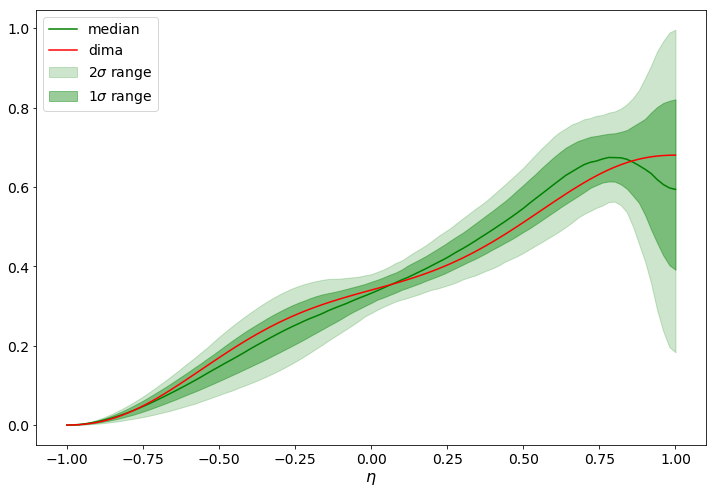

In [17]:
#plt.fill_between(xnew, p0, p100, alpha=0.1, color='green', label='IQ100')
plt.fill_between(xnew, p25, p975, alpha=0.2, color='green', label=r'2$\sigma$ range')
plt.fill_between(xnew, p16, p84, alpha=0.4, color='green', label=r'1$\sigma$ range')
plt.plot(xnew, p50, color='g', label='median')
plt.plot(xnew, dima, c='r', label='dima')
plt.gca().set_xlabel(r'$\eta$')
plt.legend(loc='upper left')
plt.savefig('envelope.png')

# Fit back to original models
How good does it approximate the original functions?

greco bestfit
[-0.0385048  -0.06582916]
dragon bestfit
[ 0.02740688 -0.05306115]
dima
[-0.09864319 -0.04548407]
dima-
[-0.08441567 -0.01965498]
dima+
[-0.11287197 -0.07131556]
H3
[0.50124356 0.01237278]
H2
[0.33903877 0.06282936]
H1
[0.10743922 0.11075213]
nominal (lab)
[-0.42909964  0.14359366]
new baseline
[ 0.00787528 -0.05768778]
MSU 2
[-0.20517976 -0.03327829]


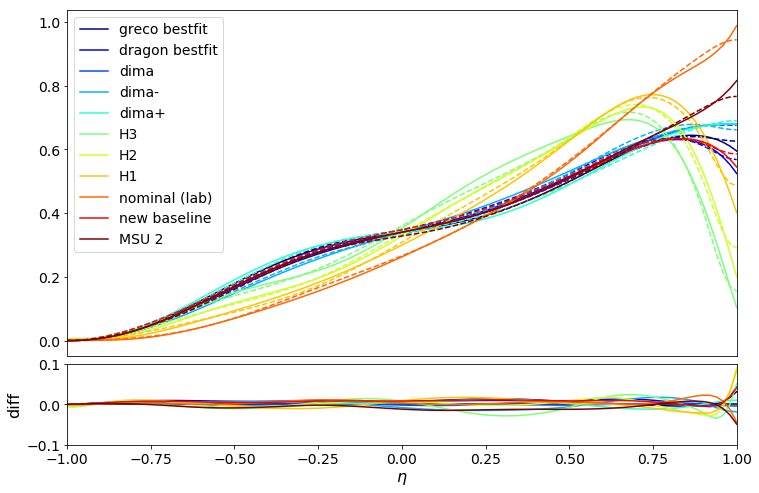

In [18]:
def fun(params, target):
    diff = ang(params, xnew) - target
    return np.sqrt(np.sum(np.square(diff)))

fig = plt.figure()
ax1 = plt.subplot2grid((10,1), (0,0), rowspan=8, fig=fig)
ax2 = plt.subplot2grid((10,1), (8,0),sharex=ax1,rowspan=2, fig=fig)

approx_params = []

for target, name, color in zip(targets, names, colors):
    
    opt = optimize.minimize(fun, x0=np.zeros(out.shape[1]), method='L-BFGS-B', args=(target)) 
    approx_params.append(opt['x'])
    print name
    print opt['x']

    new = ang(opt['x'], xnew)
    ax1.plot(xnew, new, '--', c=color)
    ax1.plot(xnew, target, label=name, c=color)
    ax2.plot(xnew, new - target, c=color)

approx_params = np.stack(approx_params)

ax1.set_xlim([-1,1])
ax2.set_xlim([-1,1])
ax1.get_xaxis().set_visible(False)

ax2.set_ylim([-0.1, 0.1])
ax2.hlines(0,-1,1)
ax2.set_ylabel('diff')
ax2.set_xlabel(r'$\eta$')

ax1.legend(loc='upper left')
plt.show()
fig.savefig('approx_new.png')

# morph from one to another model
Let's have some fun by morphing from dima to H2 in a couple intermediate steps

/home/peller/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/peller/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


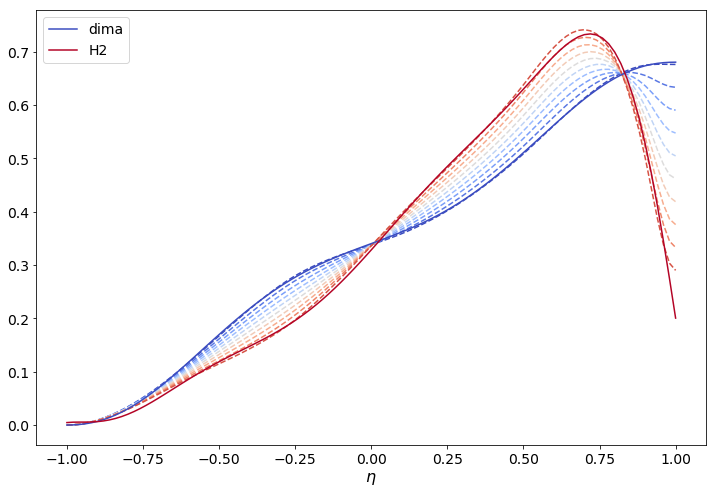

In [19]:

n = 10.
p1 = np.linspace(approx_params[2,0], approx_params[6,0], n, endpoint=True)
p2 = np.linspace(approx_params[2,1], approx_params[6,1], n, endpoint=True)

cmap = cm.coolwarm

for i in range(int(n)):
    plt.plot(xnew, ang([p1[i],p2[i]], xnew), c=cmap(i/n), ls='--')
    
plt.plot(xnew, dima, color=cmap(0.), label='dima')
plt.plot(xnew, h2_model, color=cmap(1.), label='H2')
plt.legend()
plt.gca().set_xlabel(r'$\eta$')

plt.savefig('morph.png')

# make it into a small python module

In [64]:
module_src = '''
from __future__ import division
import numpy as np
from scipy.interpolate import make_interp_spline
from scipy.integrate import quad

'''

module_src += 'support_x = np.%s'%repr(support_x)
module_src += '\ncomponents = np.%s'%repr(transformer.components_)
module_src += '\nmean = np.%s'%repr(transformer.mean_)
module_src += '''

def transform(p):
    return np.dot(p, components) + mean


def ang(params, values):
    """
    New angular acceptance funcion
    
    params : list / array
        the two parametrrs p1 and p2
    values : float, list, array
        the eta values to compute the angular acceptance for in (-1, 1)
    """
    assert np.all(np.logical_and(np.greater_equal(values, -1), np.less_equal(values, 1))), 'values must be in range -1, 1'
    transformed_params = transform(params)
    f = make_interp_spline(support_x, transformed_params, bc_type=([(1, 0.0)], [(1, 0.0)]))
    positive_f = lambda x : np.clip(f(x), 0., None)
    
    norm = quad(positive_f, -1, 1)
    out = positive_f(values)
    #normalize....why 0.68?
    out /= norm[0] / 0.68
    
    return out

'''

with open('unified_angular_acceptance.py', 'w') as f:
    f.write(module_src)

In [60]:
exec(module_src)

In [63]:
ang([0,0], [0,1,1,1,1])

array([0.33176673, 0.58701616, 0.58701616, 0.58701616, 0.58701616])

In [65]:
from unified_angular_acceptance import ang

In [ ]:
ang